In [ ]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import convolve2d
import cv2

In [ ]:
# Modulo de funciones de Gradiente

def Sobel(img):

    K0 = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
    K45 = [[-2,-1, 0], [-1, 0, 1], [0,1,2]]
    K90 = [[-1, 0, 1], [-2, 0, 2], [-1,0,1]]
    K135 = [[0, 1, 2], [-1, 0, 1], [-2,-1,0]]
    #K180 = [[1, 2, 1], [0, 0, 0], [-1,-2,-1]]
    #K225 = [[2, 1, 0], [1, 0, -1], [0,-1,-2]]
    #K270 = [[1, 0, -1], [2, 0, -2], [1,0,-1]]
    #K315 = [[0, -1, -2], [1, 0, -1], [2,1,0]]

    K0 = np.asmatrix(K0)
    K45 = np.asmatrix(K45)
    K90 = np.asmatrix(K90)
    K135 = np.asmatrix(K135)
    #K180 = np.asmatrix(K180)
    #K225 = np.asmatrix(K225)
    #K270 = np.asmatrix(K270)
    #K315 = np.asmatrix(K315)

    G0 = convolve2d(img, K0, 'same')
    G45 = convolve2d(img, K45, 'same')
    G90 = convolve2d(img, K90, 'same')
    G135 = convolve2d(img, K135, 'same')
    #G180 = convolve2d(img, K180, 'same')
    #G225 = convolve2d(img, K225, 'same')
    #G270 = convolve2d(img, K270, 'same')
    #G315 = convolve2d(img, K315, 'same')


    rows = G0.shape[0]
    cols = G0.shape[1]
    Module = np.zeros((rows,cols))
    Phase = np.zeros((rows,cols))
    for i in range(0,rows):
        for j in range(0,cols):
            Module[i,j] = (np.sqrt(G0[i,j]**2)+np.sqrt(G45[i,j]**2)+np.sqrt(G90[i,j]**2)+np.sqrt(G135[i,j]**2))/16
            #Phase[i,j] = np.arctan(Gy[i,j]/Gx[i,j])


    return Module,G0,G45,G90,G135

In [ ]:
# Modulo de filtrado mediante Kernel
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

from matplotlib import cm

def plot_kernel(data, ax=None):
    rows, cols = data.shape
    y, x = np.meshgrid(np.arange(rows),np.arange(cols),indexing='ij')
    if ax == None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    _min, _max = (np.min(data), np.max(data))
    ax.plot_surface(x, y, data.T, cmap=cm.jet, vmin=_min, vmax=_max)

def plot_images_and_kernel(img, img_filt, kernel):
    fig = plt.figure(figsize=(17,5))
    ax1 = fig.add_subplot(131)
    ax1.imshow(img, 'gray')
    ax1.title.set_text('Input image')
    ax2 = fig.add_subplot(132)
    ax2.imshow(img_filt, 'gray')
    ax2.title.set_text('Filtered image')
    ax3 = fig.add_subplot(133, projection='3d')
    plot_kernel(kernel, ax=ax3)
    ax3.title.set_text('Kernel')
    plt.show()

# Box (pasabajos)

def Box(n=1):

    int(n)
    if (n % 2 != 0):
        kernel = np.ones((n,n)) # box cuadrado de unos
        kernel /= kernel.sum()  # se normaliza
        return kernel
    else:
        return print("Ingrese un tamaño de kernel impar")

In [ ]:
# Modulo de morfología


def _morph_op(img, se, fcn):
    '''Implements a general morphologic operation.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2)), 'edge')
    img_out = np.zeros(img.shape)
    for r,c in np.ndindex(img.shape):
        img_out[r,c] = fcn(img_pad[r:r+rk,c:c+ck][se_flip])
    return img_out

def _morph_multiband(img, se, argfcn):
    '''Implements a general morphologic operation on a mutichannel image based on the first channel.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2), (0,0)), 'edge')
    img_out = np.zeros(img.shape)
    rse, cse = np.where(se_flip)
    for r,c in np.ndindex(img.shape[:2]):
        loc = argfcn(img_pad[r:r+rk,c:c+ck,0][se_flip])
        img_out[r,c] = img_pad[r+rse[loc],c+cse[loc]]
    return img_out

def _morph_color(img, se, argfcn):
    '''Applies a morphological operation to a color image based on the
    Y-channel.
    '''
    img2 = (rgb2yiq(img)[:, :, 0])[:, :, np.newaxis]
    img2 = np.concatenate((img2, img),axis=2)
    result = _morph_multiband(img2, se, argfcn)[:, :, 1:]
    return result

def im_dilate(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.max)
    else:
        return _morph_color(img, se, np.argmax)


# Box y Circle

def Box_Morf(n=1):
    int(n)
    if (n % 2 != 0):
        box = np.ones((n,n),dtype=bool) # box cuadrado de bool
        return box
    else:
        return print("Ingrese un tamaño de elemento impar")


def Circle_Morf(n=1):

    if (n % 2 != 0):
        circle = np.ones((n,n),dtype=bool)
        circle[1,1] = False
        circle[1,n-1] = False
        circle[n-1,1] = False
        circle[n-1,n-1] = False
        return circle
    else:
        return print("Ingrese un tamaño de elemento impar")


# Operaciones basicas (nivel 1):

# 1) Dilatación:
def Dilatacion(img, se):
    if img.ndim == 2:
        return _morph_op(img, se, np.max)
    else:
        return _morph_color(img, se, np.argmax)

# 2) Erosión:
def Erosion(img, se):
    if img.ndim == 2:
        return _morph_op(img, se, np.min)
    else:
        return _morph_color(img, se, np.argmin)


# Operaciones de suma/resta entre erosión y dilatación:

# 1) Borde externo:
def Borde_Externo(img, se):
    return (Dilatacion(img, se)-img)

# 2) Borde interno:
def Borde_Interno(img, se):
    return (img-Erosion(img, se))

# 3) Gradiente:
def Gradiente(img, se):
    return (Dilatacion(img, se)-Erosion(img, se))

# Operaciones concatenando dilatación y erosión (nivel 2):

# 1) Apertura (opening): erosion y luego dilatacion
def Apertura(img, se):
    img2 = Erosion(img, se)
    return (Dilatacion(img2,se))

# 2) Cierre (closing): dilatacion y erosion luego
def Cierre(img, se):
    img2 = Dilatacion(img, se)
    return (Erosion(img2,se))

# 3) Top-hat: img - apertura (iris)
def TopHat(img, se):
    return (img-Apertura(img, se))

# 4) Bottom-hat
def BottomHat(img, se):
    return (Cierre(img, se)-img)

# Operaciones concatenando cierre y apertura (nivel 3):

# 1) OC: open-close:
def OC(img, se):
    img2 = Apertura(img, se)
    return (Cierre(img2, se))

# 2) CO: close-open:
def CO(img, se):
    img2 = Cierre(img, se)
    return (Apertura(img2, se))


#Funciones útiles a partir de operaciones morfológicas:

#Suavizado. Puede calcularse como el promedio entre operaciones del mismo nivel. (pasabajos)
def Suavizado(img, se, nivel):

    int(nivel)
    if (nivel==1):
        return ((Dilatacion(img,se)+Erosion(img,se))/2)
    elif (nivel==2):
        return ((Apertura(img,se)+Cierre(img,se))/2)
    elif (nivel==3):
        return ((OC(img,se)+CO(img,se))/2)
    else:
        print("Ingrese un nivel ENTERO entre 1 y 3.")


#Realce de contraste (agregar una "porción" de pasaaltos, donde el pasaaltos puede construirse a partir del smoothing). (pasaaltos)
def Realce(img,se,nivel,alfa):
    return (img+alfa*(img-Suavizado(img,se,nivel)))

def Umbral(img,u):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j]>=u:
                img[i,j]=1
            else:
                img[i,j]=0

    return img

In [ ]:
# Función que aplica Sobel a la imagen y un Blur 3x3.

def Cargado_Sobel_Blur(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    Module,G0,G45,G90,G135 = Sobel(img_gray)
    plt.imshow(Module,'gray')
    plt.show()
    img2 = convolve2d(np.clip(Module,0,255),Box(3))

    return img2


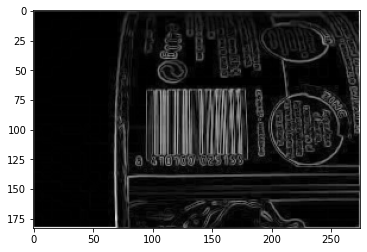

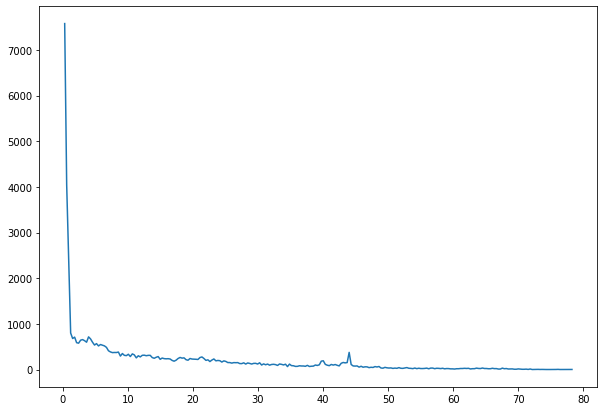

In [ ]:
# Se realiza el Sobel y el Blur 3x3 junto con el histograma de luminancias (debe cargarse previamente la imagen al entorno de Colab)

hist,bins = np.histogram(Cargado_Sobel_Blur(cv2.imread('/content/barcode-1.jpg')),256)
fig = plt.figure(figsize = (10,7))
plt.plot(bins[1::],hist)
plt.show()

In [ ]:
# Función que aplica un umbral a la imagen

def Umbral(img):
    img3 = img.copy()

    _,th= cv2.threshold(img3,200,255,cv2.THRESH_BINARY)
    #plt.imshow(th,'gray')
    #plt.show

    img4 = th.copy()

    return img4

In [ ]:
# Función de Morfología que aplica el cierre, la erosión y dilatación correspondientes luego de la umbralización.
def Morfologia(img):

    img5 = Cierre(img,Box_Morf(3))
    #plt.imshow(img5,'gray')
    #plt.show

    img6 = Erosion(img5,Box_Morf(7))
    img7 = Dilatacion(img6,Box_Morf(3))

    #fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #axes[0].imshow(img_gray, 'gray')
    #axes[1].imshow(imgy, 'gray')

    #plt.show

    return img7

In [ ]:
# Función que halla los contornos en la imagen

def Contornos(img,img_original):

    # find contours:
    # img en 8 bits,
    # RETR_EXTERNAL: devuelve solo los contornos externos (no los internos)
    # CHAIN_APROX_SIMPLE: almacena solamente los vértices del contorno. NO todas las rectas (ahorra memoria)


    cnts, hierarchy = cv2.findContours(np.uint8(img),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # se ordena CNTS con criterio "contourArea" y se toma el mayor

    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

    # crea el rectangulo a partir de los vertices

    rect = cv2.minAreaRect(c) # se crea un box 2d con la menor área posible
    box = np.int0(cv2.boxPoints(rect)) # Se transforma el box 2d en 4 puntos (vértices del rectangulo) y se convierten a integer

    # dibuja los contornos en la imagen
    cv2.drawContours(img_original, [box], -1, (0, 255, 0), 2)
    # se le pasa: la imagen, los contornos, el color de los contornos , y el ancho del contorno


    imagen_final = cv2.resize(img_original, None, fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
    #cv2.imshow("Image", image)
    #cv2.waitKey(0)

    return imagen_final

In [ ]:
# Lectura de CB, NO implementado aún.

#import pyzbar.pyzbar as zbar

"""
from pyzbar.pyzbar import decode

def Decodificacion(img):

    #img = cv2.imread(imagename)
    #cv2.imshow('imagen',img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    #cv2.show()
    barcodes = decode(img)
    print(barcodes)


    #for barcode in barcodes:
    #    barcodeData = barcode.data.decode("utf-8")
    #    barcodeType = barcode.type
    #    print("Codigo de barras encontrado: ", barcodeData)

    return barcodes
"""

In [ ]:
# Función que aplica todas las operaciones necesarias del proceso de reconocimiento de contornos:
# Secuencia de trabajo: Cargado->Sobel->Blur->Umbral->Operaciones Morfológicas->Reconocimiento Contornos

def Analizar(imagename):
    img = cv2.imread(imagename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_final = Contornos(Morfologia(Umbral(Cargado_Sobel_Blur(img))),img)

    return img_final

In [ ]:
# Bloque de interfaz

import tkinter as tk
from PIL import Image,ImageTk

root = tk.Tk()
root.title("Escáner de codigo de barras")


# Funciones
#----------------------------------------------------------------------------------#

def Cargar_Imagen(): # Permite que el usuario cargue una imagen desde su directorio local.
    from tkinter import filedialog

    global img,imagename

    imagename = filedialog.askopenfilename()
    img = Image.open(imagename)
    #img = img.resize((img_label_width,img_label_height))
    img.thumbnail((img_label_width,img_label_height))
    img = ImageTk.PhotoImage(img)
    img_label.config(image=img)

def Analizar_Imagen(): # Aplica el análisis de la imagen en busca del reconocimiento del CB.

    global img_analizada,img_analizada2

    img_analizada = Analizar(imagename)
    img_analizada = Image.fromarray(img_analizada)
    img_analizada.thumbnail((img_label_width,img_label_height))
    img_analizada2 = ImageTk.PhotoImage(img_analizada)
    img2_label.config(image=img_analizada2)

def Guardar_Imagen(): # Permite al usurario guardar el resultado del análisis en su directorio local.

    img_analizada.save(fp="Resultado Analisis Barra.png")


def Decodificar_Imagen(): # Decodifica el CB. NO implementado aún

    global codigo

    #codigo = Decodificacion(img)
    #code_label.config(text = codigo)


#----------------------------------------------------------------------------------#


title_label = tk.Label(text= "Detector de Código de barras", font=('Courier',20),justify=tk.CENTER)
title_label.grid(row=0,column=2,columnspan=1)

# Botones y Labels
#----------------------------------------------------------------------------------#
# LADO IZQUIERDO

img_label_width = 300
img_label_height = 300
img1 = Image.open('fase coffee.png')
#img1 = img1.resize((img_label_width,img_label_height))
img1 = ImageTk.PhotoImage(img1)
img_label = tk.Label(image=img1, width=img_label_width, height=img_label_height)
img_label.grid(column=1,row=1)

cargar = tk.StringVar()
cargar_btn = tk.Button(root, textvariable=cargar,command = Cargar_Imagen)
cargar.set("Cargar")
cargar_btn.grid(column=1,row=3)
#------------------------------------------#
# LADO DERECHO

img2 = Image.open('fase coffee.png')
#img2 = img1.resize((img_label_width,img_label_height))
img2 = ImageTk.PhotoImage(img2)
img2_label = tk.Label(image=img2, width=img_label_width, height=img_label_height)
img2_label.grid(column=3,row=1)

analizar = tk.StringVar()
analizar_btn = tk.Button(root, textvariable=analizar, command = Analizar_Imagen)
analizar.set("Analizar")
analizar_btn.grid(column=2,row=1)

guardar = tk.StringVar()
guardar_btn = tk.Button(root, textvariable=guardar, command=Guardar_Imagen)
guardar.set("Guardar")
guardar_btn.grid(column=4,row=1)

code_label = tk.Label(text= "vacio")
code_label.grid(column=3,row=3)

decodificar = tk.StringVar()
decodificar_btn = tk.Button(root, textvariable=decodificar, command=Decodificar_Imagen)
decodificar.set("Decodificar")
decodificar_btn.grid(column=3,row=2)

copiar = tk.StringVar()
copiar_btn = tk.Button(root, textvariable=copiar)
copiar.set("Copiar")
copiar_btn.grid(column=4,row=3)

"""codigo = tk.StringVar()
codigo_btn = tk.Button(root, textvariable=codigo)
codigo.set("-")
codigo_btn.grid(column=3,row=2)"""


#----------------------------------------------------------------------------------#



root.mainloop()

TclError: ignored